In [1]:
from plot import tier1_plot
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()

# AMAZON / AWSDNS eval

2024-04-26 12:19:14.125 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_AMAZON_ns_awsdns.pickle'
2024-04-26 12:19:14.526 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:14.528 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:14.534 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=300.59 [km], 1 hostnames
2024-04-26 12:19:14.538 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=1427.26 [km]
2024-04-26 12:19:14.539 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:14.540 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:14.541 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:14.542 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:14.543 | INFO     | plot:tier1_plot:224 - file='results__

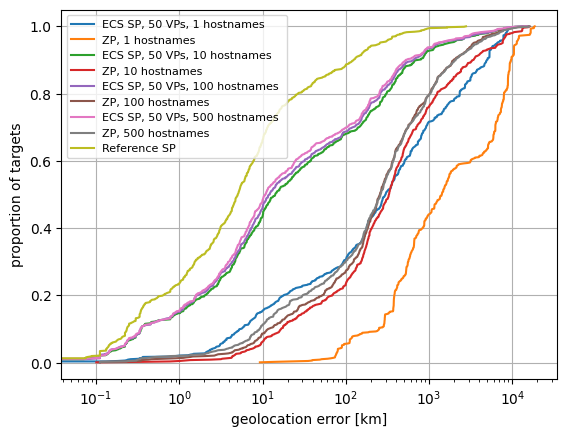

2024-04-26 12:19:16.422 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_AMAZON_ns_awsdns.pickle'
2024-04-26 12:19:16.771 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:16.772 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:16.778 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=9.98 [km], 1 hostnames
2024-04-26 12:19:16.779 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:16.780 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:16.781 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:16.782 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:16.783 | INFO     | plot:tier1_plot:224 - file='results__10_hostname_AMAZON_ns_awsdns.pickle'
2024-04-26 12:19:17.227 | INFO     | plot:plot_per_granularity:125 - len(total_ho

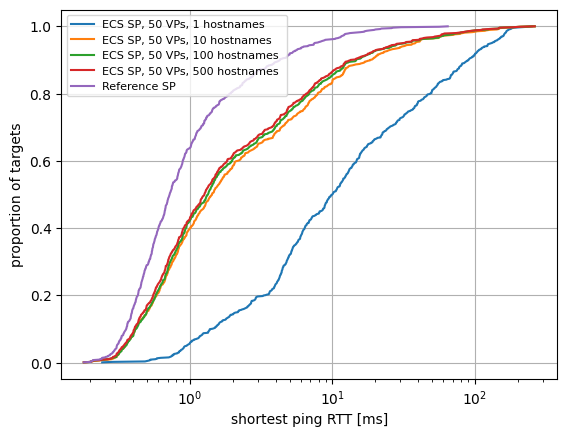

In [2]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AMAZON"],
)

tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="rtt",
    filter_org=["AMAZON"],
)

# GOOGLE analysis

2024-04-26 12:19:18.746 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_GOOGLE_ns_google.pickle'
2024-04-26 12:19:19.302 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:19.303 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:19.307 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=52.58 [km], 1 hostnames
2024-04-26 12:19:19.310 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=816.54 [km]
2024-04-26 12:19:19.311 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:19.312 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:19.312 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:19.313 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:19.314 | INFO     | plot:tier1_plot:224 - file='results__10

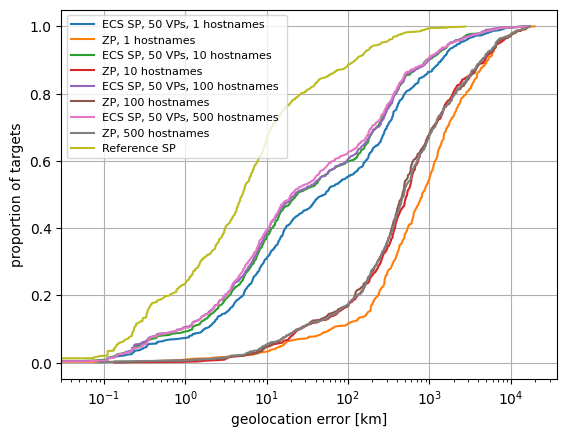

In [3]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["GOOGLE"],
)

# AKAMAI evaluation

2024-04-26 12:19:21.385 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_AKAMAI_ns_akamai.pickle'


2024-04-26 12:19:21.501 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:21.503 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:21.508 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=109.29 [km], 1 hostnames
2024-04-26 12:19:21.511 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=340.43 [km]
2024-04-26 12:19:21.512 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:21.513 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:21.515 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:21.516 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:21.517 | INFO     | plot:tier1_plot:224 - file='results__10_hostname_AKAMAI_ns_akamai.pickle'
2024-04-26 12:19:22.076 | INFO     | plot:plot_per_granularity:125 - len(t

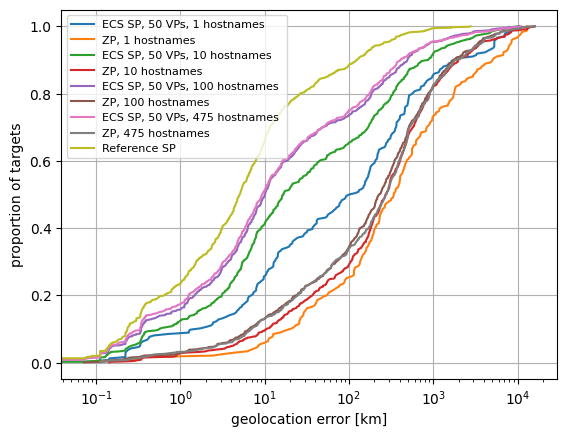

In [4]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AKAMAI"],
)

# INCAPSULA evaluation

2024-04-26 12:19:24.022 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_INCAPSULA_ns_impervadns.pickle'


2024-04-26 12:19:24.272 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:24.273 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:24.278 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=44.61 [km], 1 hostnames
2024-04-26 12:19:24.281 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=511.1 [km]
2024-04-26 12:19:24.281 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:24.282 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:24.283 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:24.283 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:24.284 | INFO     | plot:tier1_plot:224 - file='results__10_hostname_INCAPSULA_ns_impervadns.pickle'
2024-04-26 12:19:24.717 | INFO     | plot:plot_per_granularity:125 - 

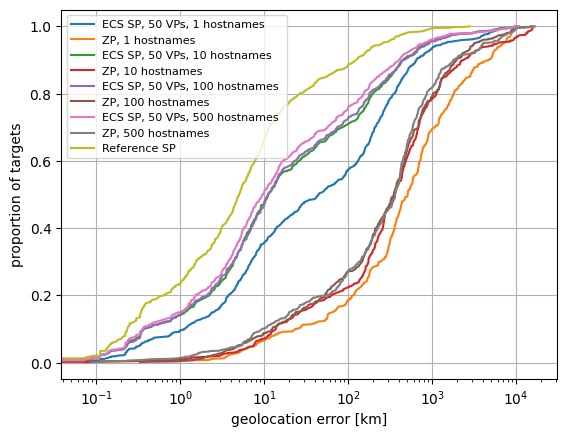

In [5]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["INCAPSULA"],
)

# AS-HOSTINGER evaluation

2024-04-26 12:19:25.966 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_AS-HOSTINGER_ns_dns-parking.pickle'
2024-04-26 12:19:26.009 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:26.010 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:26.013 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=165.41 [km], 1 hostnames
2024-04-26 12:19:26.015 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=1216.22 [km]
2024-04-26 12:19:26.016 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:26.016 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:26.017 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:26.018 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:26.018 | INFO     | plot:tier1_plot:224 - file

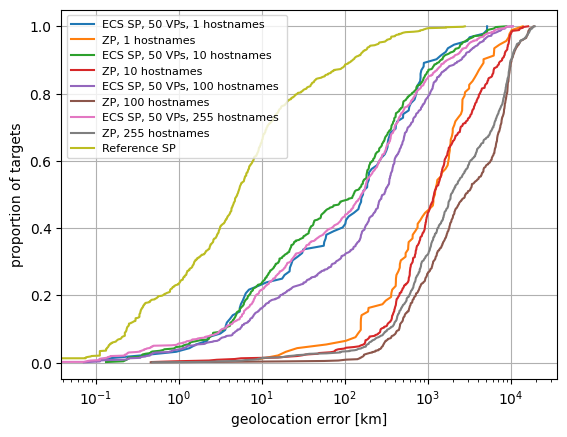

In [6]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["AS-HOSTINGER"],
)

# CDN77 evaluation

2024-04-26 12:19:27.755 | INFO     | plot:tier1_plot:224 - file='results__1_hostname_CDN77_ns_bunny.pickle'


2024-04-26 12:19:28.045 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:28.048 | INFO     | plot:plot_per_granularity:126 - nb targets:: 759
2024-04-26 12:19:28.053 | INFO     | plot:plot_per_granularity:158 - ECS shortest ping:: jaccard, 50 VPs, median_error=125.99 [km], 1 hostnames
2024-04-26 12:19:28.056 | INFO     | plot:plot_per_granularity:186 - Zero ping:: jaccard, median_error=1352.14 [km]
2024-04-26 12:19:28.057 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:28.059 | INFO     | plot:plot_per_granularity:125 - len(total_hostnames)=1
2024-04-26 12:19:28.060 | INFO     | plot:plot_per_granularity:126 - nb targets:: 0
2024-04-26 12:19:28.061 | INFO     | plot:plot_per_granularity:188 - ###############################
2024-04-26 12:19:28.062 | INFO     | plot:tier1_plot:224 - file='results__10_hostname_CDN77_ns_bunny.pickle'
2024-04-26 12:19:28.339 | INFO     | plot:plot_per_granularity:125 - len(to

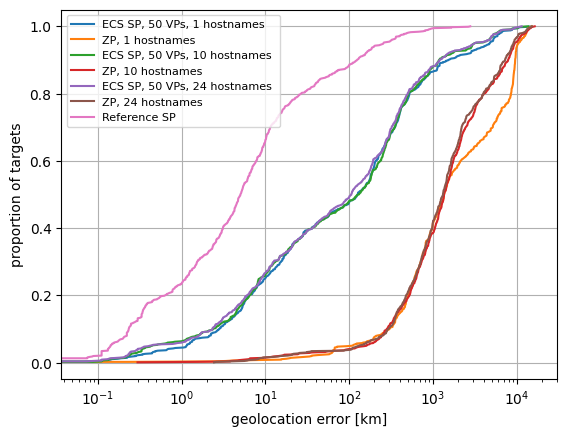

In [7]:
tier1_plot(
    eval_dir=path_settings.RESULTS_PATH / "tier1_evaluation/",
    granularities=["answer_subnets"],
    probing_budgets_evaluated=[50],
    metric_evaluated="d_error",
    filter_org=["CDN77"],
)